In [1]:
import gzip
import pickle

import sys, os
from os import path
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from tueplots import figsizes, fonts, bundles
from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 150})

## Runtime

In [2]:
with gzip.open(path.join("benchmark_results", "runtimes.pkl.gz"), "rb") as f:
    data = pickle.load(f)

In [3]:
output_file_runtime = 'benchmark_results/runtime.pdf'

In [4]:
r = data['repetitions']
n_samples = data['n_samples']
del data['repetitions']
del data['n_samples']

In [5]:
plt.rcParams.update({'figure.figsize': (2/3*5.511811263318113, 2/3*2.480315068493151)})

JaxTSNE [ 2.13721151  2.07757292  3.68574324  6.54551105 14.52489333]
sklearnBarnesHutTSNE [ 0.47243915  2.55416694  6.72536755 14.30704098 25.47097526]
openTSNEFFT [11.29766693 18.84319553 23.53887191 27.42189784 32.33179216]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Roboto Condensed


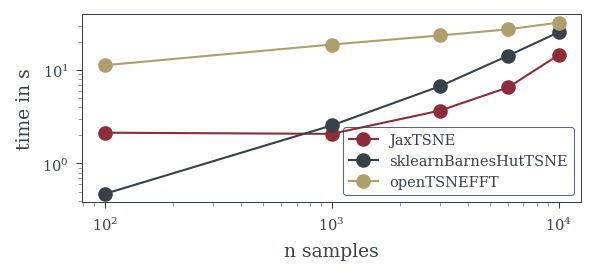

In [6]:
with plt.rc_context(bundles.beamer_moml()):
    plt.rcParams.update({'figure.figsize': (0.7*5.511811263318113, 0.7*2.480315068493151)})
    fig, ax = plt.subplots()
    for key, value in data.items():
        means = np.mean(value, axis=1)
        print(key, means)
        stds = np.std(value, axis=1)
        ax.errorbar(n_samples, means, fmt='o-',
                    label=key)
    #plt.plot(n_samples, [i**1 for i in n_samples], c='grey', linewidth=0.2)
    #plt.plot(n_samples, [i**2 for i in n_samples], c='grey', linewidth=0.2)
    #plt.plot(n_samples, [i**3 for i in n_samples], c='grey', linewidth=0.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.legend()
    ax.set_xlabel('n samples')
    ax.set_ylabel('time in s')
    plt.savefig(output_file_runtime)
    

## tnse plot

In [7]:
from benchmark import load_data
from sklearn.manifold import TSNE as SKLTSNE
import openTSNE
from tsne_jax import tsne as JaxTSNE
output_file_plot = 'benchmark_results/tsneplot.pdf'

In [8]:
x, y = load_data(1000)

In [9]:
Y = SKLTSNE(
    early_exaggeration=4,
    learning_rate=200,
    angle=0.5,
    perplexity=30.0,
    init='random',
    method='barnes_hut',
    verbose=True,
    random_state=42
).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.564333
[t-SNE] KL divergence after 250 iterations with early exaggeration: 15.655133
[t-SNE] KL divergence after 1000 iterations: 1.000676


In [10]:
affinity = openTSNE.affinity.PerplexityBasedNN(
            x,
            perplexity=30.0,
            method="annoy",
            random_state=1,
            verbose=True)
init = openTSNE.initialization.random(
            x, n_components=2, random_state=1
        )
embedding = openTSNE.TSNEEmbedding(
            init,
            affinity,
            learning_rate=200,
            negative_gradient_method="fft",
            random_state=42,
            verbose=True,
        )
embedding.optimize(250, exaggeration=4, momentum=0.8, inplace=True)
embedding.optimize(750, momentum=0.5, inplace=True)

===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.38 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.05 seconds
===> Running optimization with exaggeration=4.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.4528, 50 iterations in 0.6105 sec
Iteration  100, KL divergence 2.5278, 50 iterations in 0.6102 sec
Iteration  150, KL divergence 2.5300, 50 iterations in 0.6097 sec
Iteration  200, KL divergence 2.5300, 50 iterations in 0.6122 sec
Iteration  250, KL divergence 2.5300, 50 iterations in 0.6098 sec
   --> Time elapsed: 3.05 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 1.3917, 50 iterations in 0.6075 sec
Iteration  100, KL divergence 1.1911, 50 iterations in 0.6068 sec
Iteration  150, KL divergence 1.1149, 50 iterations in 0.6078 sec
Iteration  200, KL divergence 1.0811, 50 iterations in 0.6065 sec
Iteration  

TSNEEmbedding([[-22.64335135,  20.0175374 ],
               [-29.31227806,  -0.52144663],
               [ 20.37097447,  12.21610871],
               ...,
               [-26.68831882,  -2.14106924],
               [-28.60909892,   0.30957088],
               [ -3.80486144,  39.75289633]])

In [11]:
jaxY = JaxTSNE(X=x, no_dims=2, initial_dims=50, perplexity=30.0, learning_rate=200, max_iter=1000, key=42, exaggeration=4.)

Computing pairwise distances...
Starting binary search
Entered binary search function


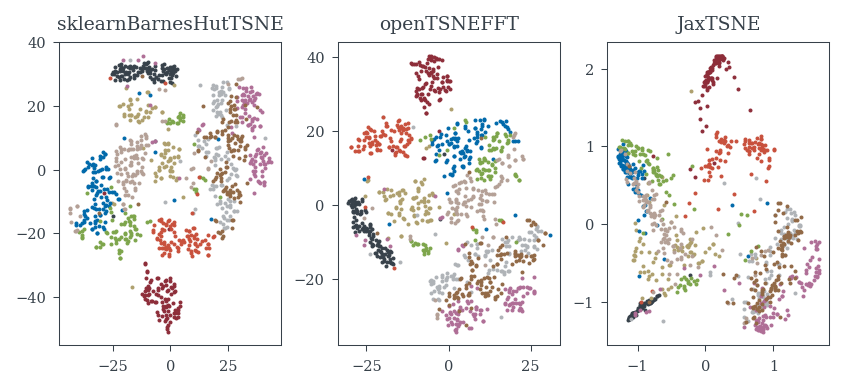

In [12]:
plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
with plt.rc_context(bundles.beamer_moml()):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
    for i in range(10):
        where = y==i
        ax1.scatter(Y[where, 0], Y[where, 1], s=2)
        ax1.set_title('sklearnBarnesHutTSNE')
    for i in range(10):
        where = y==i
        ax2.scatter(embedding[where, 0], embedding[where, 1], s=2)
        ax2.set_title('openTSNEFFT')
    for i in range(10):
        where = y==i
        ax3.scatter(jaxY[where, 0], jaxY[where, 1], s=2)
        ax3.set_title('JaxTSNE')
    plt.savefig(output_file_plot)